Gaussian Models for Texture Synthesis
=====================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour explores texture synthesis using Gaussian random fields.
Image synthesis is obtained by drawing an image at random from a random distribution that
is learned from an input texture exemplar.


We use here the spot noise model developped in


B. Galerne, Y. Gousseau and J.-M. Morel,
_Random Phase Textures: Theory and Synthesis_, IEEE Transactions on Image
Processing, 20(1), pp. 257-267, 2011.


We derive this model as being a Maximamu Likelihood Estimate (MLE)
of a stationary Gaussian
vector parameters from a single input texture. Although this is not the original
derivation of the model, it is stricly equivalent to the method of
Galerne et al.

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *
#from nt_solutions import graphics_1_synthesis_gaussian as solutions

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Gaussian Modeling of Textures
-----------------------------
We consider the modeling of textures $f \in \RR^N$ of $N$ pixels using a Gaussian
random vector $ X \sim \Nn(\mu,\Si) $. Here $\mu \in \RR^N$ is the
mean of the distribution and $\Si \in \RR^{N \times N}$ is a symmetric
semi-definite positive covariance matrix.


We recall that formally a random vector is a mapping $X : \Om \rightarrow
\RR^N$ where $\Om$ is a probalized space.


_Texture analysis_ corresponds to learning both $\mu$ and $\Si$ from a
single exemplar texture $f_0 \in \RR^N$. For this learning to be
feasible, since the number of free parameters is enormous, additional
assumptions on the distribution are required. We suppose here that the
texture model is stationary, i.e. all translates $X(\cdot+\tau)$ have
the same distribition for all $\tau \in \ZZ^2$ (we assume here periodic
boundary conditions for simplicity).


_Texture synthesis_ corresponds to computing a realization $f = X(\xi) \in \RR^N$
where $\xi \in \Om$, from the random vector $X$. Since $X$ is
Gaussian distributed, this can be achieved by computing $ f = U w+\mu $
where $U \in \RR^{N \times N}$ is any matrix that factorize the
covariance as $\Si = UU^*$ and $w$ is a realisation of a random vector
of distribution $\Nn(0,\text{Id}_N)$, which is a Gaussian white noise.
In the following, this computation is caried over very easily because the
factorization of the covariance is explicitely given during the
estimation step.



Load a color textured image $f$.

In [2]:
n = 512
f = load_image("nt_toolbox/data/wood.jpg", n, grayscale=0)

Display it.

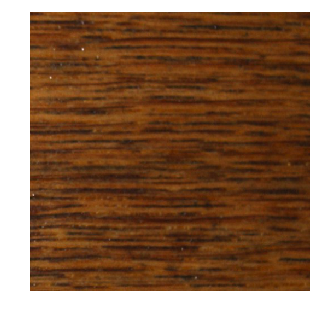

In [3]:
plt.figure(figsize = (5,5))
imageplot(f)

Periodic + Smooth Image Decomposition
-------------------------------------
To avoid boundary artifact, we replace the original image $f$
by its periodic component $p$, which is computed as detailed in:


L. Moisan, _Periodic plus Smooth Image Decomposition_, Journal of
Mathematical Imaging and Vision, vol 39:2, pp. 161-179, 2011.



The periodic component $p$ is the solution of the folowing linear
system

$$ \choice{
      \Delta p = \Delta_i f \\
      \sum_k p(k) = \sum_k f(k)
  }
$$

where $\Delta$ is a finite difference Laplacian with periodic boundary
conditions, and $\Delta_i$ is the same Laplacian but with reflecting
boundary conditions.


We first extend the original input image by symmetry to obtain $f_e \in \RR^{(n+2) \times (n+2)} $.
Note that the extension of a color image is obtained by extending each
channel.

In [4]:
z = np.zeros([1,1,np.shape(f)[2]])

fe_high   = np.hstack((np.hstack((z,f[[0],:,:])),z))
fe_middle = np.hstack((np.hstack((f[:,[0],:],f)),f[:,[-1],:]))
fe_low    = np.hstack((np.hstack((z,f[[-1],:,:])),z))
fe = np.vstack((fe_high, np.vstack((fe_middle, fe_low))))

Compute the inner-Laplacian $d = \Delta_i f$ as the usual Laplacian of the
extended image $\Delta f_e$.

In [5]:
def circshift(x,v):
    x = np.roll(x,v[0], axis = 0)
    x = np.roll(x,v[1], axis = 1)
    return x

laplacian = lambda x: 4*x - (circshift(x, [0,1]) + circshift(x, [1,0]) + circshift(x, [-1,0]) + circshift(x, [0,-1]))
d = laplacian(fe)
d = d[1:-1, 1:-1, :]

We solve the linear system $ \Delta p = d $ (assuming now periodic boundary conditions
for the Laplacian) using the Fourier transform
$$ \forall \om \neq 0, \quad \hat p(\om) = \frac{\hat d(\om)}{
    \hat U(\om) } \qwhereq
      \hat U(\om) = 4 - 2\cos\pa{\frac{2 \om_1 \pi}{n}} - 2\cos\pa{\frac{2 \om_2 \pi}{n}},  $$
together with the conservation of the mean constraint
$$ \hat p(0) = \sum_k f(k). $$


Here, the discrete Fourier transform of an image $f \in \RR^{n \times n}$ is defined as
$$ \forall (\om_1,\om_2) \in \{0,\ldots,n\}^2, \quad
      \hat p(\om) = \sum_{k_1=0}^{n-1} \sum_{k_2=0}^{n-1}
      p(k) e^{\frac{2 i \pi}{n} (k_1 \om_1 + k_2 \om_2) } $$
Note that for a color image, this coefficient is a vector in $\RR^3$ obtained by
transforming each channel. The Fourier transform is computed in
$O(N\log(N))$ operations with the FFT algorithm (for 2-D image, use the
fft2 command).


Compute the Laplacian transform map $\hat U(\om)$.

In [6]:
[X, Y] = np.meshgrid(np.arange(0,n), np.arange(0,n))
U = 4 - 2*np.cos(2*X*np.pi/n) - 2*np.cos(2*Y*np.pi/n)

Inverse the Laplacian.

In [7]:
from pylab import fft

U_extended = np.zeros([n,n,np.shape(f)[2]])
for i in range(np.shape(f)[2]):
    U_extended[:,:,i] = U
    
P = pyl.fft2(d, axes = (0,1))/U_extended
P[0, 0, :] = np.sum(np.sum(f, 0), 0)
p = np.real(pyl.ifft2(P, axes = (0,1)))

Compare the periodic tilings of $f_0$ and $f$.

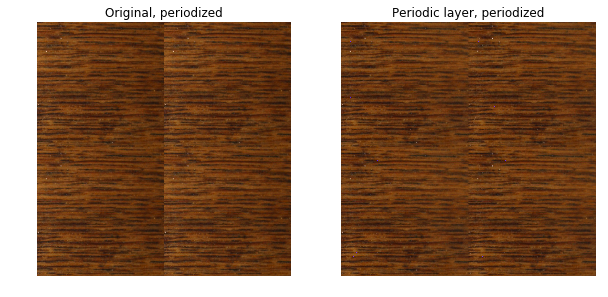

In [8]:
mydisp = lambda x: np.vstack((np.hstack((x,x)),np.hstack((x,x))))

plt.figure(figsize = (10,10))
imageplot(mydisp(f), 'Original, periodized', [1,2,1])
imageplot(mydisp(p), 'Periodic layer, periodized', [1,2,2])

__Exercise 1__

Compare the log of the modulus of the Fourier transforms of the input image $f$
and its periodic component $p$. What do you observe ?

In [9]:
#solutions.exo1()

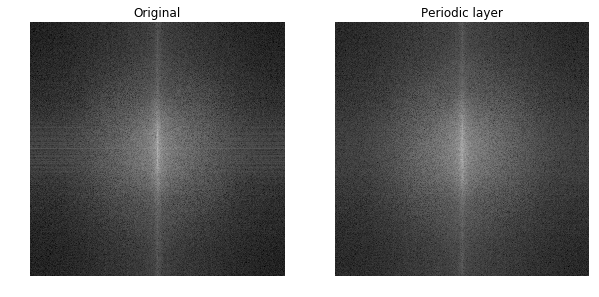

In [10]:
## Insert your code here.

mydisp = lambda x: np.log10(abs(pyl.fftshift(x,axes=(0,1))) + 1e-5)

plt.figure(figsize = (10,10))
imageplot(np.mean(mydisp(pyl.fft2(f, axes=(0,1))),2), 'Original', [1, 2, 1])
imageplot(np.mean(mydisp(pyl.fft2(p, axes=(0,1))),2), 'Periodic layer', [1, 2, 2])

Spot Noise Texture Synthesis
----------------------------
In the spot noise Gaussian texture model, the covariance $\Si$ is learned as the
empirical covariance of the texture input $f_0$.


Assign $f_0$ to the be the intensity of the periodic component of the input
exemplar.

In [11]:
f0 = np.mean(p,2)

Display it.

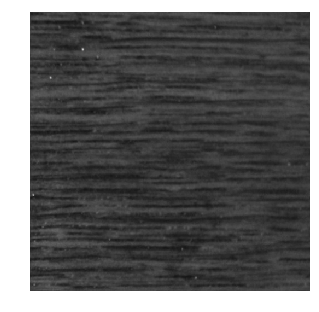

In [12]:
u = f0
u[0,0] = 0
u[1,0] = 1

plt.figure(figsize = (5,5))
imageplot(clamp(u))

Exploiting the stationarity of the model, the empirical covariance is
computed as
$$ \forall i,j, \quad \Si_{i,j} = \frac{1}{N} \sum_k f_0(i+k) f_0(j+k), $$
Using such an empirical covariance can be understood as using a maximum
likelihood estimator (MLE) of the covariance.


This defines a cyclic covariance matrix.
It means that $\Si$ is a
convolution operator
$$ \forall h \in \RR^N, \quad \Si h = s \star h $$
where $\star$ denotes the periodic convolution
$$ \forall a, b \in \RR^N, \quad a \star b(k) = \sum_{\ell} a(\ell) b(k-\ell) $$
(remember that the indexes $k,\ell$ are actually 2-D indexes)
where the filter $s \in \RR^N$ is the auto-correlation of the input
exemplar
$$ s = \frac{1}{N} f_0 \star \tilde f_0
  \qwhereq \tilde a(k)=a(-k).  $$


Since the model is stationary, the mean $\mu \in \RR^N$ is a constant image
$$ \mu = \frac{1}{N} \sum_k f_0(k). $$


This model can be expressed using the Fourier transform, using the power
spectrum which is the Fourier transform of the covariance filter
$$ \hat s(\om) = \frac{1}{N} \abs{\hat f_0(\om)}^2~. $$


Since the covariance $\Si$ is defined in a factored form $s = f_0
\star \tilde f_0$, sampling a realization from this Gaussian
distribution is straightforward, since it only requires computing
$$ f = f_0 \star w $$
where $ w $ is a realization of a Gaussian white noise of distribution
$\Nn(N^{-1},N^{-1/2}\text{Id}_N)$.


Generate a realization $w$ of this white noise.

In [13]:
from numpy import random

w = random.standard_normal([n,n])/n
w = w-np.mean(w) + 1/n**2

Compute the convolution $f_0 \star w$, which defines the synthesized result.

In [14]:
f = np.real(pyl.ifft2(pyl.fft2(f0)*pyl.fft2(w)))

Display the result.

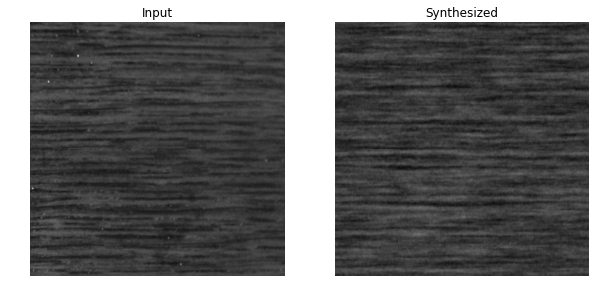

In [15]:
plt.figure(figsize = (10,10))

u = f0
u[0,0] = 0
u[1,0] = 1
imageplot(clamp(u), 'Input', [1,2,1])

u = f
u[0,0] = 0
u[1,0] = 1
imageplot(clamp(u), 'Synthesized', [1,2,2])

__Exercise 2__

Compare the histograms of the input and synthesized textures pixel empirical distributions.

In [16]:
#solutions.exo2()

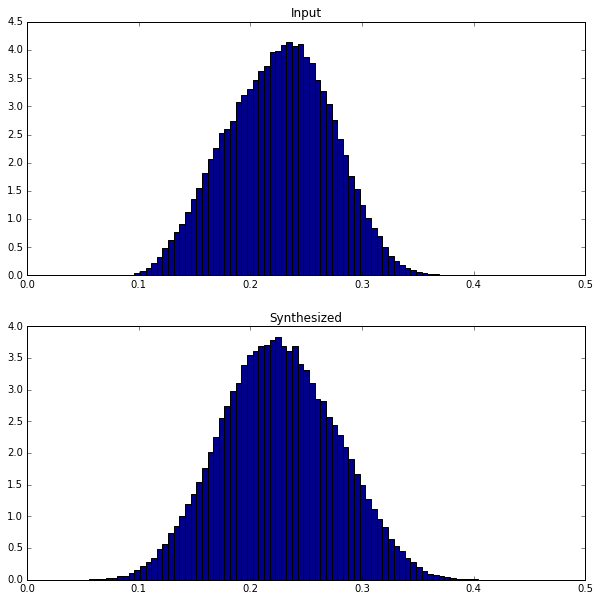

In [17]:
## Insert your code here.

k = 100
t = np.linspace(0,.5,k)

plt.figure(figsize = (10,10))

plt.subplot(2, 1, 1)
plt.bar(t[:-1], np.histogram(f0,t)[0]*k/n**2, width = 1/200, color = "darkblue")
plt.title('Input')

plt.subplot(2, 1, 2)
plt.bar(t[:-1], np.histogram(f,t)[0]*k/n**2, width = 1/200, color = "darkblue")
plt.title('Synthesized')

plt.show()

Color Spot Noise Texture Synthesis
----------------------------------
Synthesis of color textures is obtained by extending the previous Gaussian
model to vector valued images.


Assign $f_0$ to the be the periodic component of the color input
exemplar.

In [18]:
f0 = p

A color image is a vector valued image $f_0 \in \RR^{N \times d}$, where here $d=3$.


A Gaussian field $\Nn(\mu,\Si)$ to model color textures makes use of a covariance
$\Si \in \RR^{ (Nd) \times (Nd) }$. Equivalently, it can be thought as
a collection $ (\Si_{i,j})_{i,j=0}^{N-1} $ of small covariances
matrices $ \Si_{i,j} \in \RR^{d \times d} $ that encode the
cross-correlations between the $d$ channels of pixels $i$ and $j$.


The maximum likelihood estimation (MLE) of $\Si$ from a single exemplar $f_0 \in \RR^{N \times d}$
is
$$ \Si_{i,j} = \frac{1}{N} \sum_k f(i+k) f(j+k)^* \in \RR^{d \times d} $$
where $f(j+k)^*$ denotes the transposed-conjugated vector.
Note that each entry of the matrix field $ (\Si_{i,j})_{i,j} $ is a
convolution mapping.


Since the model is assumed to be
stationary, this covariance operates in a block-diagonal way over the
Fourier transform, which means that for any vector-valued image $f \in \RR^{N \times d} $
$$ y = \Si f \quad\text{ is computed as }\quad
  \hat y(\om) = \hat \Si(\om) \hat f(\om) $$
where $\hat f(\om) \in \CC^d$ is the 2-D Fourier transform of each
channel, and $ \hat \Si(\om) \in \RR^{d \times d} $ encodes the
cross-correlation of the different channels at some frequency $\om$.


In the special case where $\Si$ is defined as the MLE from an input
exemplar $f_0$, each of these matrices is actually a rank-1 matrix
$$ \hat \Si(\om) = \hat f_0(\om)\hat f_0(\om)^*. $$


This property is crucial, because it defines the covariance in a factored
form. Using the fact that $ \hat f_0(\om) \in \CC^d $ is the leading
eigenvector of $\hat \Si(\om) $ and that there is only a single non zero eigenvalue, this
allows one to draw a realization $f \in \RR^{N \times d}$ from a random
vector distributed according to
$\Nn(\mu,\Si)$ as
$$ \hat f(\om) = \hat w(\om) \hat f_0(\om), $$
where $\hat w(\om) \in \CC$, $\hat f_0(\om) \in \CC^d$,
with $ w \in \RR^N $ being a realization of a Gaussian white noise
$\Nn(N^{-1},N^{-1/2}\text{Id}_N)$.


Equivalently, if one denotes $f_0 = (f_0^{[j]})_{j=0}^{d-1}$ the different channels
$ f_0^{[j]} \in \RR^N $, this corresponds to convolving each channel with the same white noise realization
$$ \forall j=0,\ldots,d-1, \quad
      f^{[j]} = f_0^{[j]} \star w. $$

__Exercise 3__

Perform the color texture synthesis.

In [19]:
#solutions.exo3()

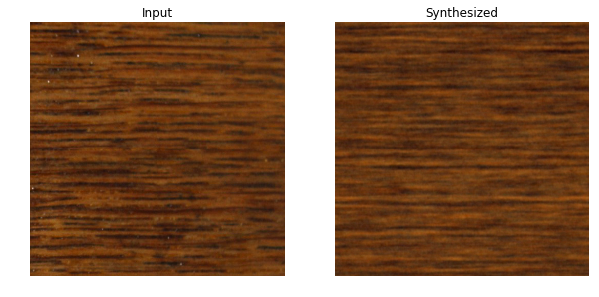

In [20]:
## Insert your code here.

w_transf = pyl.fft2(w)
w_transf_extended = np.zeros([n,n,np.shape(f0)[2]])
for i in range(np.shape(f0)[2]):
    w_transf_extended[:,:,i] = w_transf
    
f = np.real(pyl.ifft2(pyl.fft2(f0, axes=(0,1))*w_transf_extended, axes=(0,1)))

plt.figure(figsize = (10,10))

u = f0
u[0,0] = 0
u[1,0] = 1
imageplot(clamp(u), 'Input', [1,2,1])

u = f
u[0,0] = 0
u[1,0] = 1
imageplot(clamp(u), 'Synthesized', [1,2,2])

__Exercise 4__

Compute several realizations of the color texture synthesis.

In [21]:
#solutions.exo4()

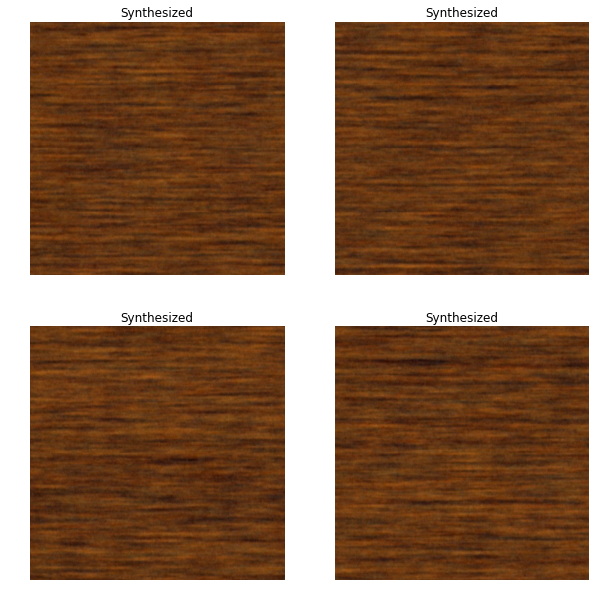

In [22]:
## Insert your code here.

plt.figure(figsize = (10,10))

for i in range(4):
    w = random.standard_normal([n,n])/n
    w = w-np.mean(w) + 1/n**2
    
    w_transf = pyl.fft2(w)
    w_transf_extended = np.zeros([n,n,np.shape(f0)[2]])
    for k in range(np.shape(f0)[2]):
        w_transf_extended[:,:,k] = w_transf
        
    f = np.real(pyl.ifft2(pyl.fft2(f0, axes =(0,1))*w_transf_extended, axes =(0,1)))

    u = f
    u[0,0] = 0
    u[1,0] = 1
    imageplot(clamp(u), 'Synthesized', [2,2,i+1])

Spot Noise Extension
--------------------
To synthesize textures of larger size $n_0 \times n_0$, we use the spot noise extension
proposed by Galerne et al.


Target synthesis size $n_0$.

In [23]:
n0 = n*2

The extended spot $f_1 \in \RR^{n_0 \times n_0 \times d}$ is computed
as
$$ f_1(k)  = \mu_0 + g(k) \frac{n_0}{n} (f_0(k)-m) \xi_{R_0}(k) $$
where $\mu_0 \in \RR^3$ is the mean of the input texture
$$ \mu_0 = \frac{1}{N} \sum_k f_0(k) $$
and where $\xi_{R_0}$ is the indicator function of a region $R_0$ of
size $n \times n$ pixels over which the input texture $f_0$ is
defined.


Note the multiplicative factor $n_0/n$ that ensures that $f_1$ has the
same variance as $f_0$.


The image
$$ g(k) = \psi(k_1)\psi(k_2), \quad g \in \RR^{n \times n} $$
makes use of a smooth windowing function $\psi$,
that varies from 0 to 1 over a small interval of size $a>0$.
This helps to remove discontinuities artifacts.


Transition width.

In [24]:
a = 10/n

Define the $\psi$ mapping.

In [25]:
phi = lambda t: np.sin(t/a*np.pi/2)**2
psi = lambda t: phi(t)*(t < a) + (t >= a)*(t <= 1-a) + phi(1-t)*(t > 1-a)

Define the $g$ windowing mask.

In [26]:
t = np.linspace(0, 1, n)
g = psi(t)*np.transpose(psi(t))

g_extended = np.zeros([n,n,np.shape(f0)[2]])
for i in range(np.shape(f0)[2]):
    g_extended[:,:,i] = g
g = g_extended     

Create the extended spot $f_1$.

In [27]:

mu0 = np.tile(np.mean(np.mean(f0, 0), 0), (n,n,1))
f1 = np.tile(np.mean(np.mean(f0, 0), 0), (n0,n0,1))
f1[n0//2 - n//2:n0//2 + n//2, n0//2 - n//2:n0//2 + n//2, :] = mu0 + n0/n*g*(f0-mu0)

Display it.

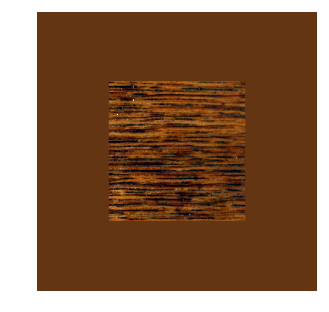

In [28]:
u = f1
u[0,0] = 0
u[1,0] = 1
plt.figure(figsize = (5,5))
imageplot(clamp(u))

__Exercise 5__

Perform the color texture synthesis using this extended spot noise.

In [29]:
#solutions.exo5()

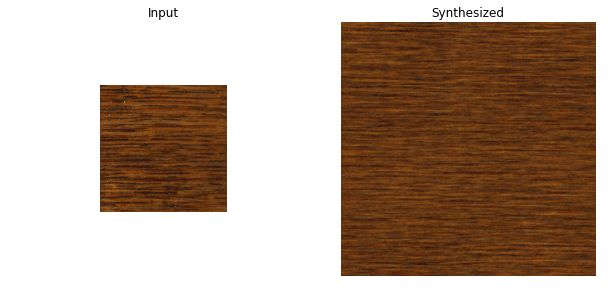

In [30]:
## Insert your code here.

w = random.standard_normal([n0,n0])/n0
w = w-np.mean(w) + 1/n0**2

w_transf = pyl.fft2(w)
w_transf_extended = np.zeros([n0,n0,np.shape(f0)[2]])
for i in range(np.shape(f0)[2]):
    w_transf_extended[:,:,i] = w_transf
    
f = np.real(pyl.ifft2(pyl.fft2(f1, axes=(0,1))*w_transf_extended, axes=(0,1)))

plt.figure(figsize = (10,10))

u = np.ones([n0,n0,3])
u[n0//2 - n//2 :n0//2 + n//2, n0//2 - n//2:n0//2 + n//2, :] = f0
u[0,0,:] = 0
u[1,0,:] = 1
imageplot(clamp(u), 'Input', [1,2,1])

u = f
u[0,0,:] = 0
u[1,0,:] = 1
imageplot(clamp(u), 'Synthesized', [1,2,2])